# Crypto Scam Risk Model

A machine learning model to detect risk for cryptocurrencies based on a variety of factors. 

### Author: Ryan Kemmer

# Configure CoinGecko API and fetch token ids

In [5]:
from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()
all_coins = cg.get_coins_list()

#create list of coin ids
coin_ids = []
for coin in all_coins:
    coin_ids.append(coin['id'])

10465

# Pull all price and token data

In [141]:
import time
from tqdm import tqdm

price_data_arr = []
summary_data_arr = []
for i in tqdm(range(len(coin_ids))):

    time.sleep(3)

    fetched = False

    try:
        price_data = cg.get_coin_market_chart_by_id(id = coin_ids[i], vs_currency='usd', days = 10000)
        summary_data = cg.get_coin_ticker_by_id(id = coin_ids[i])
    except Exception as e:
        print('couldnt fetch')
        print(e)
        pass
    
    price_data_arr.append(price_data)
    summary_data_arr.append(summary_data)

    i +=1
    

 41%|████      | 4316/10471 [5:07:03<76:04:11, 44.49s/it]

couldnt fetch
HTTPSConnectionPool(host='api.coingecko.com', port=443): Read timed out. (read timeout=120)


 60%|█████▉    | 6277/10471 [7:20:06<4:33:17,  3.91s/it]

couldnt fetch
{'error': 'Could not find coin with the given id'}


 60%|█████▉    | 6278/10471 [7:20:09<4:21:34,  3.74s/it]

couldnt fetch
{'error': 'Could not find coin with the given id'}


 71%|███████   | 7401/10471 [8:34:13<3:12:53,  3.77s/it]

couldnt fetch
{'error': 'Incorrect path. Please check https://www.coingecko.com/api/'}


 80%|███████▉  | 8374/10471 [9:40:40<21:54:41, 37.62s/it]

couldnt fetch
HTTPSConnectionPool(host='api.coingecko.com', port=443): Read timed out. (read timeout=120)


 89%|████████▉ | 9326/10471 [10:37:13<1:08:19,  3.58s/it]

couldnt fetch
{'error': 'Could not find coin with the given id'}


100%|██████████| 10471/10471 [11:45:31<00:00,  4.04s/it]


# Generate features for modelling

In [145]:
from statistics import mean, stdev
import numpy as np
import pandas as pd

data_dict = {}
data_dict['Name'] = []
data_dict['Exchanges'] = []
data_dict['Target_Currencies'] = []
data_dict['Trust_Scores'] = []
data_dict['Volumes'] = []
data_dict['Bid_Ask_Spread_Percentage'] = []
data_dict['Last_Prices'] = []
data_dict['Is_Anomaly'] = []

data_dict['Prices'] = []
data_dict['Overall_Volitility'] = []
data_dict['Price_Linear_Trend'] = []
data_dict['Max_Percent_Change'] = []
data_dict['Average_Percent_Change'] = []
data_dict['Std_Percent_Change'] = []

data_dict['Unique_Exchanges'] = []
data_dict['Unique_Targets'] = []

data_dict['Average_Trust_Score'] = []
data_dict['Average_Volume'] = []
data_dict['Average_bid_ask_spread_percentages'] = []
data_dict['Average_Last_Prices'] = []
data_dict['Average_Anomaly_Score'] = []

data_dict['Std_Trust_Score'] = []
data_dict['Std_Volume'] = []
data_dict['Std_bid_ask_spread_percentages'] = []
data_dict['Std_Last_Prices'] = []
data_dict['Std_Anomaly_Score'] = []

data_dict['Label'] = []


for i, price in enumerate(summary_data_arr):

    crypto_name = summary_data_arr[i]['name']

    exchanges = []
    targets = []
    trust_scores = []
    volumes = []
    bid_ask_spread_percentages =[]
    last_prices = []
    anomalies = []
    stales = []

    #parse summary messages
    for ticker in summary_data_arr[i]['tickers']:
        
        exchange = ticker['market']['identifier']
        target = ticker['target']
        trust_score = ticker['trust_score']

        if trust_score == 'red':
            trust_score = 1
        elif trust_score == 'yellow':
            trust_score = 2
        elif trust_score == 'green':
            trust_score = 3
        else:
            trust_score = 0


        volume = ticker['volume']
        bid_ask_spread_percentage = ticker['bid_ask_spread_percentage']

        if bid_ask_spread_percentage == None:
            bid_ask_spread_percentage = 0

        last_price = ticker['last']
        anomaly = ticker['is_anomaly']

        if anomaly == True:
            anomaly = 1
        else:
            anomaly = 0

        stale = ticker['is_stale']
        if stale == True:
            stale = 1
        else:
            stale = 0

        exchanges.append(exchange)
        targets.append(target)
        trust_scores.append(trust_score)
        volumes.append(volume)
        bid_ask_spread_percentages.append(bid_ask_spread_percentage)
        last_prices.append(last_price)
        anomalies.append(anomaly)
        stales.append(stale)


    if len(exchanges) != 0:

        #parse price data
        prices = np.array(price_data_arr[i]['prices'])[:,1]

        try:

            overall_volitility = stdev(prices)

            x = np.linspace(0,prices.size,prices.size)
            fit = np.polyfit(x,prices,1)
            lin_coeff = fit[0]

            percent_changes = np.diff(prices) / prices[:-1] * 100.
            max_percent_change = max(percent_changes)
            average_percent_change = mean(percent_changes)
            std_percent_change = stdev(percent_changes)

            number_exchanges = len(set(exchanges))
            number_targets = len(set(targets))

            avg_trust_score = mean(trust_scores)
            avg_volume = mean(volumes)
            avg_bid_ask_spread_percentages = mean(bid_ask_spread_percentages)
            avg_last_prices = mean(last_prices)
            avg_anomalies = mean(anomalies)

            std_trust_score = 0
            std_volume = 0
            std_bid_ask_spread_percentages = 0
            std_last_prices = 0
            std_anomalies = 0

            if len(exchanges) > 1:
                std_trust_score = stdev(trust_scores)
                std_volume = stdev(volumes)
                std_bid_ask_spread_percentages = stdev(bid_ask_spread_percentages)
                std_last_prices = stdev(last_prices)
                std_anomalies = stdev(anomalies)

            if mean(stales) == 1:
                label = 1
            else: 
                label = 0

        #append data 

            data_dict['Name'].append(crypto_name)
            data_dict['Exchanges'].append(exchanges)
            data_dict['Target_Currencies'].append(targets)
            data_dict['Trust_Scores'].append(trust_scores)
            data_dict['Volumes'].append(volumes)
            data_dict['Bid_Ask_Spread_Percentage'].append(bid_ask_spread_percentages)
            data_dict['Last_Prices'].append(last_prices)
            data_dict['Is_Anomaly'].append(anomalies)

            data_dict['Prices'].append(prices)
            data_dict['Overall_Volitility'].append(overall_volitility)
            data_dict['Price_Linear_Trend'].append(lin_coeff)
            data_dict['Max_Percent_Change'].append(max_percent_change)
            data_dict['Average_Percent_Change'].append(average_percent_change)
            data_dict['Std_Percent_Change'].append(std_percent_change)

            data_dict['Unique_Exchanges'].append(number_exchanges)
            data_dict['Unique_Targets'].append(number_targets)

            data_dict['Average_Trust_Score'].append(avg_trust_score)
            data_dict['Average_Volume'].append(avg_volume)
            data_dict['Average_bid_ask_spread_percentages'].append(avg_bid_ask_spread_percentages)
            data_dict['Average_Last_Prices'].append(avg_last_prices)
            data_dict['Average_Anomaly_Score'].append(avg_anomalies)

            data_dict['Std_Trust_Score'].append(std_trust_score)
            data_dict['Std_Volume'].append(std_volume)
            data_dict['Std_bid_ask_spread_percentages'].append(std_bid_ask_spread_percentages)
            data_dict['Std_Last_Prices'].append(std_last_prices)
            data_dict['Std_Anomaly_Score'].append(std_anomalies)

            data_dict['Label'].append(label)

        except:
            print('exception occured for ' + str(crypto_name))

full_data = pd.DataFrame.from_dict(data_dict,orient='index').transpose()

exception occured for AlgoGems
exception occured for Anji


divide by zero encountered in true_divide
invalid value encountered in true_divide


exception occured for BabelFish
exception occured for Baby Ryukyu Inu
exception occured for Blaze the cat
exception occured for Blizz Finance
exception occured for Blubber Coin
exception occured for BlueSparrow Token
exception occured for BNB Shinobi
exception occured for Bork
exception occured for Buff Shiba Inu
exception occured for Cere Network
exception occured for ChefCake
exception occured for DeFi Launch
exception occured for Doge Yellow Coin
exception occured for Dogs Of Elon
exception occured for DRACARYS
exception occured for Dragon Kart Token
exception occured for Dunes
exception occured for Dune Token
exception occured for Ethereum Name Service
exception occured for Evagrow Coin
exception occured for FalconX
exception occured for Fire Bitcoin
exception occured for Floki Gold
exception occured for FlokiLoki
exception occured for Follow Token
exception occured for Fox Finance
exception occured for Frieza Inu
exception occured for FTM PUP Token
exception occured for Galactic A

invalid value encountered in double_scalars
invalid value encountered in double_scalars


exception occured for Kaiba Inu
exception occured for Little Tsuki Inu
exception occured for Lorde Edge
exception occured for Magic Trading Token
exception occured for MegaShibaZilla
exception occured for Meta Shiba
exception occured for MintSwap
exception occured for Moneyhero
exception occured for NFTASCII
exception occured for Nole NPC
exception occured for NOMY
exception occured for NuShares
exception occured for Omicron
exception occured for Pawn My NFT
exception occured for Phore
exception occured for Pirate Boy
exception occured for Pirate Inu
exception occured for Place War
exception occured for POOMOON
exception occured for Premio
exception occured for RedZilla
exception occured for RO Slayers
exception occured for Safety
exception occured for Shibalana
exception occured for Snowbank
exception occured for Solana Inu
exception occured for SpaceBalls
exception occured for Spike Inu
exception occured for The Batdoge
exception occured for The Mars Shiba
exception occured for The P

# One hot encode data

In [3]:
df_out = full_data.assign(**pd.get_dummies(full_data['Exchanges'].apply(lambda x:pd.Series(x)).stack().reset_index(level=1,drop=True),  prefix="Exchanges_Cat").sum(level=0))
df_out = df_out.assign(**pd.get_dummies(df_out['Target_Currencies'].apply(lambda x:pd.Series(x)).stack().reset_index(level=1,drop=True),  prefix="Target_Currencies_Cat").sum(level=0))

In [4]:
exchanges_cols = [col for col in df_out if col.startswith('Exchanges_Cat')]
target_curr_cols = [col for col in df_out if col.startswith('Target_Currencies_Cat')]

for col in exchanges_cols:
    df_out.loc[(df_out[col] >= 1), col] = 1

for col in target_curr_cols:
    df_out.loc[(df_out[col] >= 1), col] = 1

# Modelling

In [9]:
from scipy import interpolate
import catboost
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import shap

In [10]:
orig_feats = ['Overall_Volitility','Price_Linear_Trend','Max_Percent_Change','Average_Percent_Change', 'Std_Percent_Change',
'Unique_Exchanges','Unique_Targets','Average_Volume','Average_bid_ask_spread_percentages','Average_Last_Prices',
'Average_Anomaly_Score', 'Std_Volume', 'Std_bid_ask_spread_percentages', 'Std_Last_Prices', 'Std_Anomaly_Score']

In [11]:
from sklearn.model_selection import train_test_split

X = df_out[[*orig_feats, *exchanges_cols, *target_curr_cols]]
y = df_out['Label'].astype(float)

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=2021)

## Train catboost model

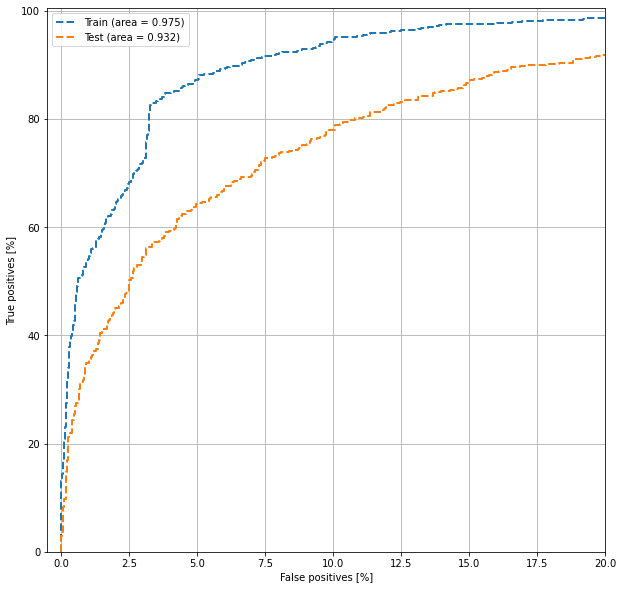

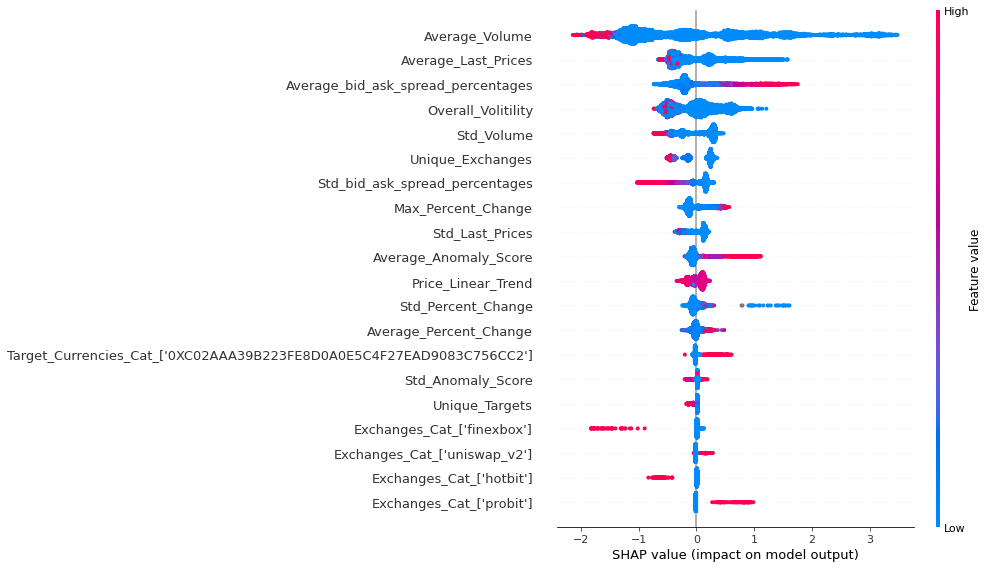

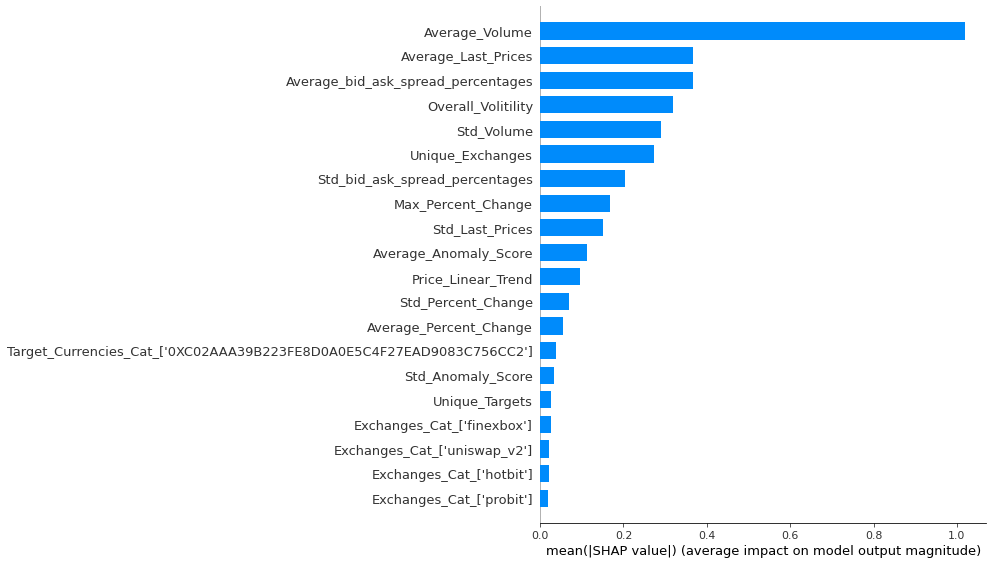

In [12]:
c = catboost.CatBoostClassifier(cat_features=[*exchanges_cols, *target_curr_cols])
c.fit(X_train, Y_train, verbose=False)

y_pred_train = c.predict_proba(X_train)[:,1]
fpr_train, tpr_train, t_train = roc_curve(Y_train,y_pred_train)
auc_train = auc(fpr_train, tpr_train)

y_pred_test = c.predict_proba(X_test)[:,1]
fpr_test, tpr_test, t_test = roc_curve(Y_test,y_pred_test)
auc_test = auc(fpr_test, tpr_test)

figure(figsize=(10, 10))
plt.plot(100*fpr_train, 100*tpr_train,'--',label= 'Train (area = {:.3f})'.format(auc_train),linewidth=2)
plt.plot(100*fpr_test, 100*tpr_test,'--',label= 'Test (area = {:.3f})'.format(auc_test),linewidth=2)
plt.xlabel('False positives [%]')
plt.ylabel('True positives [%]')
plt.xlim([-0.5,20])
plt.ylim([0,100.5])
plt.grid(True)
plt.legend(loc='best')
plt.show()

shap.initjs()
explainer = shap.TreeExplainer(c)
shap_values = explainer.shap_values(X_train, Y_train)
shap.summary_plot(shap_values, X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar')

In [17]:
scores = c.predict_proba(X)

In [20]:
coins = df_out.Name

In [29]:
final_df = pd.DataFrame()
final_df['Name'] = df_out.Name
final_df['Risk'] = scores[:,1]

In [31]:
final_df.to_csv('final_results.csv')

## Precision / Recall Statistics

AP 0.7354850742775292


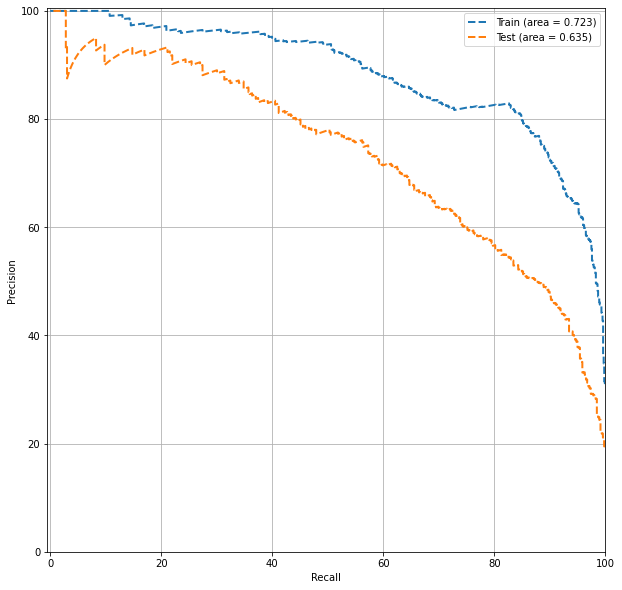

In [13]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

yhat_train = c.predict(X_train)
yhat_test = c.predict(X_test)

precision_train, recall_train, thresholds = precision_recall_curve(Y_train, y_pred_train)
precision_test, recall_test, thresholds = precision_recall_curve(Y_test, y_pred_test)
f1_train = f1_score(Y_train, yhat_train)
f1_test = f1_score(Y_test, yhat_test)

print('AP ' + str(average_precision_score(Y_test,y_pred_test)))

figure(figsize=(10, 10))
plt.plot(100*recall_train, 100*precision_train,'--',label= 'Train (area = {:.3f})'.format(f1_train),linewidth=2)
plt.plot(100*recall_test, 100*precision_test,'--',label= 'Test (area = {:.3f})'.format(f1_test),linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([-0.5,100])
plt.ylim([0,100.5])
plt.grid(True)
plt.legend(loc='best')
plt.show()

## Full PR Curve

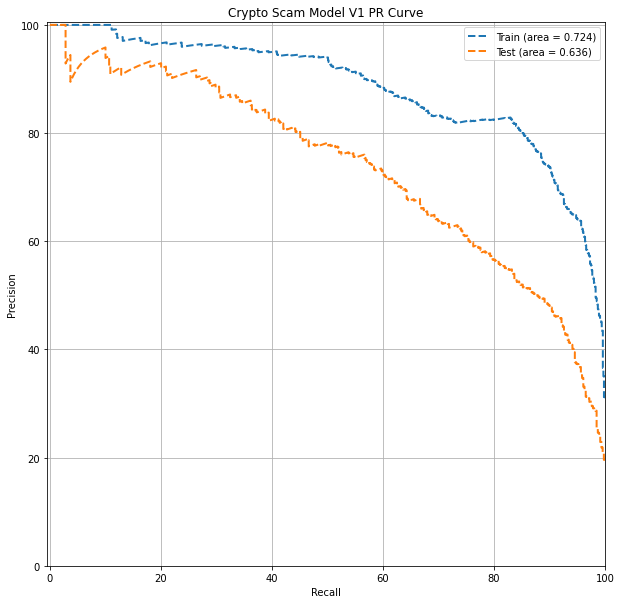

In [17]:
figure(figsize=(10, 10))
plt.plot(100*recall_train, 100*precision_train,'--',label= 'Train (area = {:.3f})'.format(f1_train),linewidth=2)
plt.plot(100*recall_test, 100*precision_test,'--',label= 'Test (area = {:.3f})'.format(f1_test),linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([-0.5,100])
plt.ylim([0,100.5])
plt.grid(True)
plt.legend(loc='best')
plt.title('Crypto Scam Model V1 PR Curve')
plt.show()

## Full ROC Curve

In [7]:
figure(figsize=(10, 10))
plt.plot(100*fpr_train, 100*tpr_train,'--',label= 'Train (area = {:.3f})'.format(auc_train),linewidth=2)
plt.plot(100*fpr_test, 100*tpr_test,'--',label= 'Test (area = {:.3f})'.format(auc_test),linewidth=2)
plt.xlabel('False positives [%]')
plt.ylabel('True positives [%]')
plt.xlim([-0.5,100])
plt.ylim([0,100.5])
plt.grid(True)
plt.legend(loc='best')
plt.title('Crypto Scam Model V1 ROC Curve')
plt.show()

NameError: name 'figure' is not defined